## Skin Deep Learning Training Notebook

In [1]:

import keras as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import tensorflow as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
%matplotlib inline
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading and Preprocessing data

In [0]:
 X, y, m, ny, nx, nc = np.load('gdrive/My Drive/Google Colab Data/Skin/temp.npy')

#### Randomizing and Normalizing DataFrame

In [0]:
#Randomizing and splitting the data set
train_X, test_X, train_y, test_y = train_test_split(X, y, \
test_size=0.10, random_state=3)
#Converting test and train y to one hot encode format
test_y = K.utils.to_categorical(test_y.transpose())
train_y = K.utils.to_categorical(train_y.transpose())


In [0]:
#Calculating train_X mean and standard deviation for normalization
train_X_mean = np.mean(train_X, axis=0)
train_X_std = np.std(train_X, axis=0)

#Normalization

train_X = ((train_X - train_X_mean)/train_X_std)
test_X = ((test_X - train_X_mean)/train_X_std)
#No variable generation for test set to prevent data leakage

### Model Building

Created model using sequential feed. Model utilies a pair of convolutional layers with 32 filters each followed by a
max pooling layer. We use dropout for regularization to avoid overfitting the model.

We repeat the above step with more granular convolutional filters. We again use dropout with a more aggressive
dropout rate to avoid overfitting the model.

We add a dense layer using the rectified linear unit as the activation function. Regularization is applied again to 
limit overfitting.

Softmax activation layer is used to predict the 7 disease categories identified by our dataset.

In [67]:
# Setting CNN Skin model

input_shape = (ny, nx, nc)
kernel_size = 4
class_num = 7

model = K.models.Sequential()
model.add(Conv2D(32, kernel_size=(kernel_size, kernel_size),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (kernel_size, kernel_size), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Conv2D(128, (kernel_size, kernel_size), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Conv2D(256, (kernel_size, kernel_size), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(class_num, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 75, 100, 32)       1568      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 37, 50, 64)        32832     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 18, 25, 64)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 18, 25, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 18, 25, 128)       131200    
__________

In [0]:
# Define optimizer (Adam optimizer)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,\
                              epsilon=None, decay=0.0, amsgrad=False)

In [0]:
# Compile the model, categorical crossentropy loss and accuracy metric
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", \
             metrics = ['accuracy'])

In [70]:
history = model.fit(train_X, train_y, batch_size = 64, epochs = 25, validation_split = .2)

Train on 7210 samples, validate on 1803 samples
Epoch 1/25
7210/7210 [==============================] - 12s 2ms/step - loss: 1.0642 - acc: 0.6609 - val_loss: 1.0388 - val_acc: 0.6744
Epoch 2/25
7210/7210 [==============================] - 10s 1ms/step - loss: 0.8899 - acc: 0.6739 - val_loss: 0.8753 - val_acc: 0.6816
Epoch 3/25
7210/7210 [==============================] - 10s 1ms/step - loss: 0.8302 - acc: 0.6902 - val_loss: 0.8506 - val_acc: 0.7033
Epoch 4/25
7210/7210 [==============================] - 10s 1ms/step - loss: 0.7963 - acc: 0.7074 - val_loss: 0.8272 - val_acc: 0.7105
Epoch 5/25
7210/7210 [==============================] - 10s 1ms/step - loss: 0.7753 - acc: 0.7200 - val_loss: 0.7858 - val_acc: 0.7304
Epoch 6/25
7210/7210 [==============================] - 10s 1ms/step - loss: 0.7481 - acc: 0.7287 - val_loss: 0.7811 - val_acc: 0.7321
Epoch 7/25
7210/7210 [==============================] - 10s 1ms/step - loss: 0.7161 - acc: 0.7393 - val_loss: 0.7644 - val_acc: 0.7415
Epoch 8

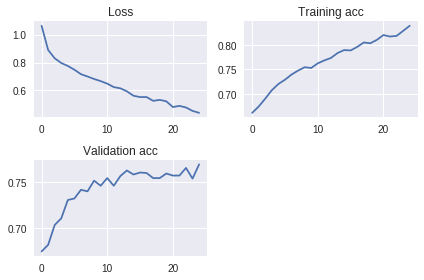

In [71]:
# Plotting training history
plt.figure()
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.title('Loss')

plt.subplot(2,2,2)
plt.plot(history.history['acc'])
plt.title('Training acc')

plt.subplot(2,2,3)
plt.plot(history.history['val_acc'])
plt.title('Validation acc')
plt.tight_layout()

In [72]:
model.evaluate(test_X, test_y)

1002/1002 [==============================] - 1s 684us/step


[0.7117268989186087, 0.7664670657492921]

In [73]:
confusion_matrix(np.argmax(test_y, axis=1), np.argmax(model.predict(test_X), axis=1))

array([[ 11,  11,   5,   0,   6,   3,   0],
       [  5,  36,   4,   0,  14,   1,   0],
       [  4,   6,  56,   0,  38,   7,   0],
       [  1,   4,   1,   2,   2,   0,   0],
       [  0,   5,  21,   1, 615,  12,   0],
       [  6,   0,  16,   0,  58,  36,   1],
       [  0,   2,   0,   0,   0,   0,  12]])

In [0]:
#Saving the model and weights for the end to end solution.

#Save weights
model.save_weights("gdrive/My Drive/Google Colab Data/Skin/skinmodelweights.h5")
model_json = model.to_json()

#Save model
with open("gdrive/My Drive/Google Colab Data/Skin/skinmodel.json", "w") as file:
  file.write(model_json)
  
#Save mean and std
np.save("gdrive/My Drive/Google Colab Data/Skin/skinmodel_meanstd.npy", [train_X_mean, train_X_std])
  


In [0]:
def img_processor(imgpath, meanstdpath, modelpath, weightspath):
  """
  inputs: 
        imgpath - path to image of potential skin cancer mole;
        meanstdpath - path to training mean & standard deviation;
        modelpath - path to Keras model;
        weightspath - path to weights for Keras model
  
  output: pred_dic - a prediction dictionary with diseases as keys and probabilities as values
  """
  
  from keras.models import model_from_json
  # load model
  with open(modelpath, "r") as file:
    loaded_json = file.read()
  skinmodel = model_from_json(loaded_json)

  # Load weights from file
  skinmodel.load_weights(weightspath)
  
  # Load mean and std
  train_X_mean, train_X_std = np.load(meanstdpath)
  
  # Loading, resizing image as np.array
  imagearray = np.asarray(Image.open(imgpath).resize((100,75)))
  imagearray = ((imagearray-train_X_mean)/train_X_std)
  ny, nx, nc = imagearray.shape
  imagearray = imagearray.reshape(1 ,ny, nx, nc)
                
  pred_vec = skinmodel.predict(imagearray).flatten()
  
  pred_dict = {'Actinic keratoses' : pred_vec[0], 'Basal cell carcinoma' : pred_vec[1],
                   'Benign keratosis-like lesions' : pred_vec[2], 'Dermatofibroma' : pred_vec[3],
                   'Melanocytic nevi' : pred_vec[4], 'Melanoma' : pred_vec[5], 'Vascular lesions' : pred_vec[6]
              }
                                      
  
  return pred_dict
  

In [0]:
drive_path = 'gdrive/My Drive/Google Colab Data/Skin/'
res = img_processor(drive_path + "HAM10000_images_part_1/ISIC_0024346.jpg", drive_path + "skinmodel_meanstd.npy",\
              drive_path + "skinmodel.json", drive_path + "skinmodelweights.h5")
print(res)

{'Actinic keratoses': 1.468158e-26, 'Basal cell carcinoma': 3.5272613e-21, 'Benign keratosis-like lesions': 5.293164e-15, 'Dermatofibroma': 2.189494e-26, 'Melanocytic nevi': 1.0, 'Melanoma': 4.6992812e-14, 'Vascular lesions': 2.305058e-30}
